Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.1614 - accuracy: 0.2163
Validation Accuracy after epoch 1: 0.32511210441589355
56/56 [==============================] - 30s 493ms/step - loss: 2.1614 - accuracy: 0.2163 - val_loss: 1.6809 - val_accuracy: 0.3251
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.8832 - accuracy: 0.3017
Validation Accuracy after epoch 2: 0.4573991000652313
56/56 [==============================] - 27s 480ms/step - loss: 1.8832 - accuracy: 0.3017 - val_loss: 1.5053 - val_accuracy: 0.4574
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.7440 - accuracy: 0.3506
Validation Accuracy after epoch 3: 0.5313901305198669
56/56 [==============================] - 27s 486ms/step - loss: 1.7440 - accuracy: 0.3506 - val_loss: 1.3772 - val_accuracy: 0.5314
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.5982 - accuracy: 0.4000
Validation Accuracy after epoch 4: 0.5560538172721863
56/56 [====

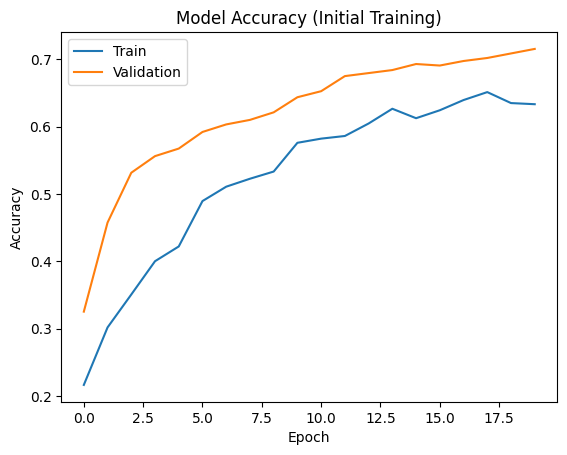

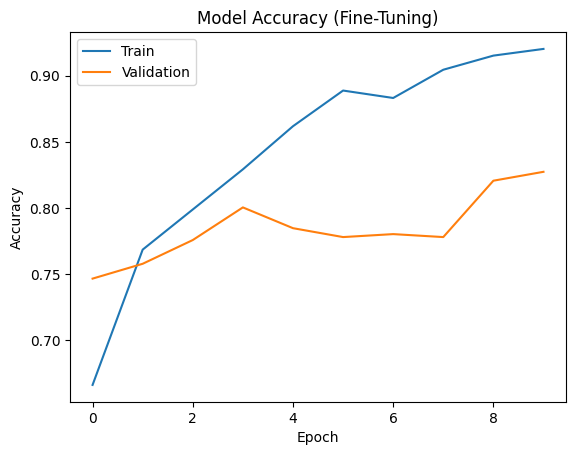

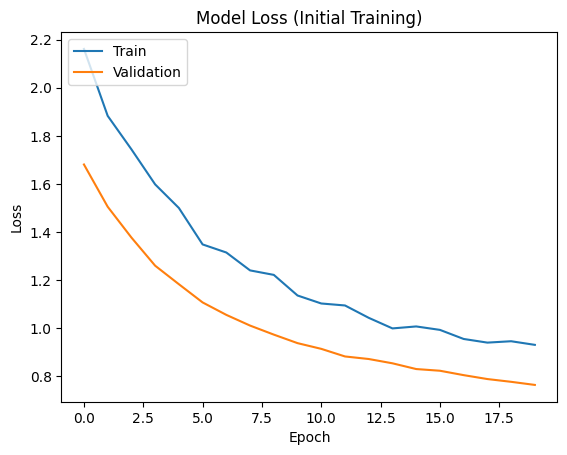

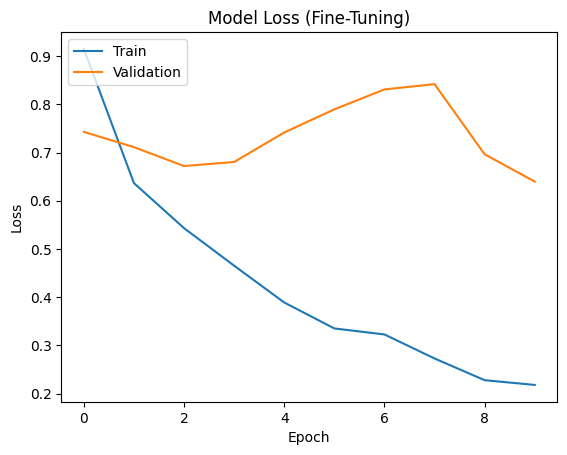

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Custom callback to print accuracy on validation data after each epoch
class ValidationAccuracyCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        _, val_accuracy = self.model.evaluate(self.X_val, self.y_val, verbose=0)
        print("\nValidation Accuracy after epoch {}: {}".format(epoch+1, val_accuracy))

# Function to read images from folders
def read_images(folder_path, label, num_images):
    X = []
    y = []
    images_read = 0
    for filename in os.listdir(folder_path):
        if images_read >= num_images:
            break
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            X.append(img)
            y.append(label)
            images_read += 1
    return X, y

# Read images from all folders
X = []
y = []
num_images_list = [501, 403, 410, 594, 600, 200]  # Increased number of images for some classes
folder_path = "/content/drive/MyDrive/TrashType_Image_Dataset"
folders = os.listdir(folder_path)

for folder, num_images in zip(folders, num_images_list):
    folder_path = os.path.join("/content/drive/MyDrive/TrashType_Image_Dataset", folder)
    images, labels = read_images(folder_path, folders.index(folder), num_images)
    X.extend(images)
    y.extend(labels)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Increased number of epochs for initial training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20,
                    validation_data=(X_test, y_test), callbacks=[ValidationAccuracyCallback(X_test, y_test)])

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model again for fine-tuning
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
fine_tuning_history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10,
                                validation_data=(X_test, y_test), callbacks=[ValidationAccuracyCallback(X_test, y_test)])

# Evaluate the model on test data after fine-tuning
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy after fine-tuning: ", accuracy)

# Plot training and validation accuracy per epoch for initial training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Initial Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy per epoch for fine-tuning
plt.plot(fine_tuning_history.history['accuracy'])
plt.plot(fine_tuning_history.history['val_accuracy'])
plt.title('Model Accuracy (Fine-Tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss per epoch for initial training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Initial Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss per epoch for fine-tuning
plt.plot(fine_tuning_history.history['loss'])
plt.plot(fine_tuning_history.history['val_loss'])
plt.title('Model Loss (Fine-Tuning)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()